# Просмотр датасета

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, mean_shift
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('dataset.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Регион,Год,Объем_сточных_вод_млн_м3,Инвестиции_в_ООС_тыс_руб,ВРП_млн_руб,ВРП_на_душу_руб,Индексы_производства_продукции_СХ_%,Доля_городского_населения_%,Использование_свеж_воды_млн_м3,Индекс_промыш_производства_%
0,Алтайский край,2000,31.0,176660.0,46736.8,17660.5,122.0,52.8,569.0,109.2
1,Алтайский край,2001,34.0,111590.0,61854.4,23509.0,104.5,53.1,599.0,109.4
2,Алтайский край,2002,36.0,67466.0,73107.4,27991.2,103.1,53.2,563.0,100.1
3,Алтайский край,2003,36.0,50114.0,88733.3,34295.8,100.8,53.5,516.0,105.5
4,Алтайский край,2004,36.0,38270.0,114840.5,44934.9,99.5,53.7,488.0,102.6


In [4]:
df.columns

Index(['Регион', 'Год', 'Объем_сточных_вод_млн_м3', 'Инвестиции_в_ООС_тыс_руб',
       'ВРП_млн_руб', 'ВРП_на_душу_руб', 'Индексы_производства_продукции_СХ_%',
       'Доля_городского_населения_%', 'Использование_свеж_воды_млн_м3',
       'Индекс_промыш_производства_%'],
      dtype='object')

In [5]:
df['Регион'].unique()

array(['Алтайский край', 'Амурская область', 'Архангельская область',
       'Астраханская область', 'Белгородская область', 'Брянская область',
       'Владимирская область', 'Волгоградская область',
       'Вологодская область', 'Воронежская область',
       'Еврейская автономная область', 'Забайкальский край',
       'Ивановская область', 'Иркутская область',
       'Кабардино-Балкарская Республика', 'Калининградская область',
       'Калужская область', 'Камчатский край',
       'Карачаево-Черкесская Республика', 'Кемеровская область — Кузбасс',
       'Кировская область', 'Костромская область', 'Краснодарский край',
       'Красноярский край', 'Курганская область', 'Курская область',
       'Ленинградская область', 'Липецкая область', 'Магаданская область',
       'Московская область', 'Мурманская область',
       'Ненецкий автономный округ', 'Нижегородская область',
       'Новгородская область', 'Новосибирская область', 'Омская область',
       'Оренбургская область', 'Орловская

# Подготовка данных для кластеризации 

Для агрегирования признаков по годам нахожу СРЕДНЕЕ за весь период (2000-2023) по конкретному региону

In [8]:
agg_features = {
    'Объем_сточных_вод_млн_м3':'mean',
    'Инвестиции_в_ООС_тыс_руб':'mean',
    'ВРП_млн_руб':'mean',
    'ВРП_на_душу_руб':'mean',
    'Индексы_производства_продукции_СХ_%':'mean',
    'Доля_городского_населения_%':'mean',
    'Использование_свеж_воды_млн_м3':'mean',
    'Индекс_промыш_производства_%':'mean'
}
agg_df = df.groupby('Регион').agg(agg_features).reset_index()
pd.set_option('display.max_rows', 10)
agg_df.head()

,Регион,Объем_сточных_вод_млн_м3,Инвестиции_в_ООС_тыс_руб,ВРП_млн_руб,ВРП_на_душу_руб,Индексы_производства_продукции_СХ_%,Доля_городского_населения_%,Использование_свеж_воды_млн_м3,Индекс_промыш_производства_%
0,Алтайский край,21.127500,5.399271e+05,399415.922679,174954.495833,103.083333,55.545833,431.719167,103.995833
1,Амурская область,78.603333,2.007445e+06,244597.249296,308259.787500,105.275000,67.120833,93.221250,103.116667
2,Архангельская область,392.086667,3.913759e+06,325785.710663,475677.907692,97.641176,76.245833,626.489583,101.717647
3,Астраханская область,60.526667,2.921741e+06,287173.118208,291875.175000,105.945833,66.229167,857.939167,107.087500
4,Белгородская область,46.700417,3.671759e+06,556404.789171,361903.037500,108.162500,65.683333,270.269167,107.091667


### Создание прокси признаков

In [10]:
# Заменил абсолютные величины, заменяю их на более относительные признаки 
agg_df['Водоемкость_ВРП'] = agg_df['Объем_сточных_вод_млн_м3']/agg_df['ВРП_млн_руб']
agg_df['Инвестиционная_активность'] = agg_df['Инвестиции_в_ООС_тыс_руб']/agg_df['ВРП_млн_руб']


Выделяю признаки, по которым будем класторизовать

In [12]:
features_clustering = [
    'ВРП_на_душу_руб','Объем_сточных_вод_млн_м3',
    'Индексы_производства_продукции_СХ_%','Доля_городского_населения_%',
    'Индекс_промыш_производства_%', 'Водоемкость_ВРП', 'Инвестиционная_активность'
]
clust_df = agg_df[features_clustering]
clust_df.head()

,ВРП_на_душу_руб,Объем_сточных_вод_млн_м3,Индексы_производства_продукции_СХ_%,Доля_городского_населения_%,Индекс_промыш_производства_%,Водоемкость_ВРП,Инвестиционная_активность
0,174954.495833,21.127500,103.083333,55.545833,103.995833,0.000053,1.351792
1,308259.787500,78.603333,105.275000,67.120833,103.116667,0.000321,8.207146
2,475677.907692,392.086667,97.641176,76.245833,101.717647,0.001204,12.013292
3,291875.175000,60.526667,105.945833,66.229167,107.087500,0.000211,10.174146
4,361903.037500,46.700417,108.162500,65.683333,107.091667,0.000084,6.599078


### Предобработка данных

In [14]:
scaler = StandardScaler()
clust_scaled = scaler.fit_transform(clust_df)

clust_scaled_df = pd.DataFrame(clust_scaled, columns = clust_df.columns, index = agg_df['Регион'])
clust_scaled_df.head()

,ВРП_на_душу_руб,Объем_сточных_вод_млн_м3,Индексы_производства_продукции_СХ_%,Доля_городского_населения_%,Индекс_промыш_производства_%,Водоемкость_ВРП,Инвестиционная_активность
Регион,,,,,,,
Алтайский край,-0.383948,-0.671890,0.289880,-1.096892,-0.405983,-1.275576,-1.027346
Амурская область,-0.186927,-0.439936,1.033742,-0.202353,-0.750405,-0.093025,0.117504
Архангельская область,0.060512,0.825186,-1.557215,0.502845,-1.298485,3.792774,0.753134
Астраханская область,-0.211143,-0.512887,1.261426,-0.271263,0.805208,-0.580168,0.445995
Белгородская область,-0.107644,-0.568686,2.013773,-0.313446,0.806841,-1.138863,-0.151045


# Кластеризация

Text(0.5, 1.0, 'Метод локтя')

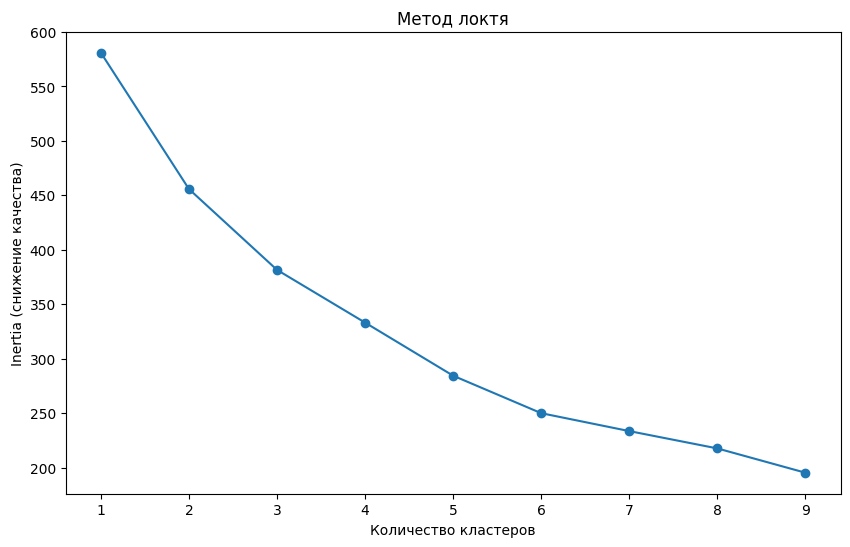

In [16]:
inertia = []
k_range = range(1, 10)  # пробуем от 1 до 9 кластеров

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clust_scaled)
    inertia.append(kmeans.inertia_)  # стоимость кластеризации

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia (снижение качества)')
plt.title('Метод локтя')

In [17]:
# Пологий спуск начинается с 3-4, я взял 3
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(clust_scaled_df)

# Добавляем номера кластеров к регионам 
agg_df['Cluster'] = clusters

# Анализируем характеристики кластеров
cluster_profile = agg_df.groupby('Cluster')[features_clustering].mean()
cluster_profile

,ВРП_на_душу_руб,Объем_сточных_вод_млн_м3,Индексы_производства_продукции_СХ_%,Доля_городского_населения_%,Индекс_промыш_производства_%,Водоемкость_ВРП,Инвестиционная_активность
Cluster,,,,,,,
0,3.981555e+05,435.481314,100.154419,79.892949,103.945518,0.000506,11.652934
1,2.992928e+05,74.543894,102.663562,65.188542,103.590038,0.000267,6.048855
2,3.270523e+05,79.572627,104.108685,63.975000,108.201554,0.000291,4.568189
3,4.315704e+06,16.960417,100.639583,76.839583,105.783542,0.000012,10.592576


### Отображение кластеров 

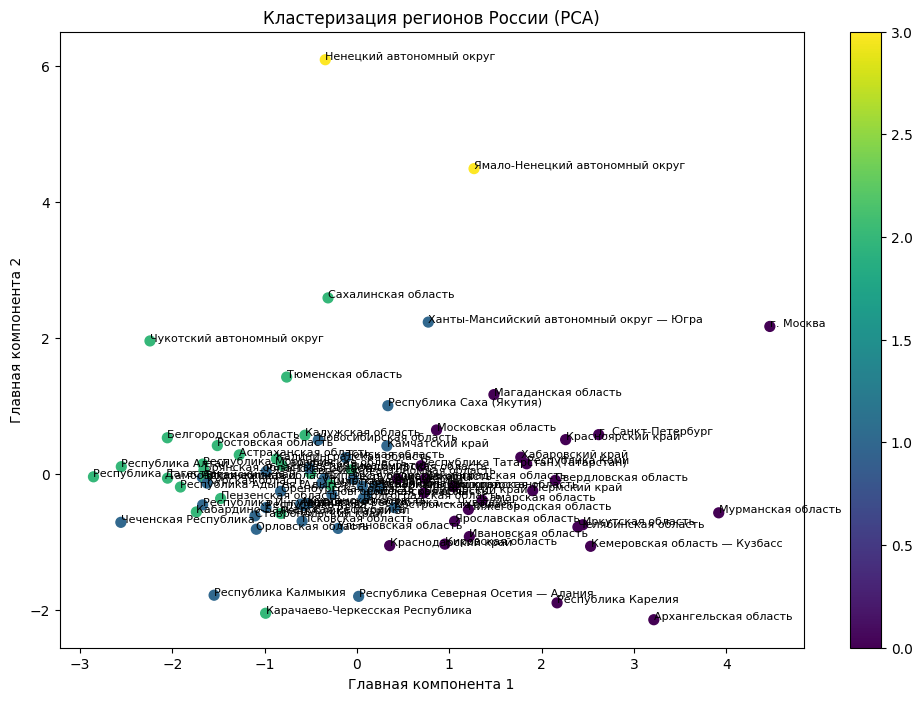

In [19]:
pca = PCA(n_components=2)# Упрощение 6 признаков до 2, чтобы нарисовать на плоскости
clust_pca = pca.fit_transform(clust_scaled_df)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(clust_pca[:, 0], clust_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title('Кластеризация регионов России (PCA)')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')

# Подписал регионы для наглядности
for i, region in enumerate(agg_df['Регион']):
    # if i % 5 == 0: 
        plt.annotate(region, (clust_pca[i, 0], clust_pca[i, 1]), fontsize=8)

In [20]:
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['Компонента_1', 'Компонента_2'],
    index=features_clustering
)
components_df

,Компонента_1,Компонента_2
ВРП_на_душу_руб,0.104844,0.724795
Объем_сточных_вод_млн_м3,0.444776,-0.016428
Индексы_производства_продукции_СХ_%,-0.492057,-0.097347
Доля_городского_населения_%,0.513053,0.230093
Индекс_промыш_производства_%,-0.278595,0.307370
Водоемкость_ВРП,0.319300,-0.556554
Инвестиционная_активность,0.325993,0.088056


In [21]:
print(cluster_profile)

# Принадлежность региона к кластеру
for cluster_num in range(optimal_k):
    print(f"\n--- Кластер {cluster_num} ---")
    regions_in_cluster = agg_df[agg_df['Cluster'] == cluster_num]['Регион'].tolist()
    print(regions_in_cluster)

         ВРП_на_душу_руб  Объем_сточных_вод_млн_м3  \
Cluster                                              
0           3.981555e+05                435.481314   
1           2.992928e+05                 74.543894   
2           3.270523e+05                 79.572627   
3           4.315704e+06                 16.960417   

         Индексы_производства_продукции_СХ_%  Доля_городского_населения_%  \
Cluster                                                                     
0                                 100.154419                    79.892949   
1                                 102.663562                    65.188542   
2                                 104.108685                    63.975000   
3                                 100.639583                    76.839583   

         Индекс_промыш_производства_%  Водоемкость_ВРП  \
Cluster                                                  
0                          103.945518         0.000506   
1                          103.590038 

### Кратковременный вывод
Модель разбила по такому принципу я предполагаю:

Кластер 0 = Городские развитые регионы с высокой экологической нагрузкой (высокие стоки, высокая урбанизация, высокие инвестиции)

Кластер 1 = Сельские бедные регионы (низкий ВРП, низкая урбанизация, развитое сельское хозяйство)

Кластер 2 = Промышленно-растущие регионы со слабыми экологическими инвестициями (средний ВРП, высокий промышленный рост, самые низкие инвестиции в ООС)

Кластер 3 = Аномально богатые ресурсные регионы (экстремально высокий ВРП, минимальные стоки, малая численность населения)

 

# Объеденение датасета с итогами кластеризации

In [24]:
# славарь с Регион -> Кластер
cluster_map = agg_df.set_index('Регион')['Cluster'].to_dict()

# Новый признак в df - Принадлежность к одному из кластеров
df['Cluster'] = df['Регион'].map(cluster_map)

df.head()

,Регион,Год,Объем_сточных_вод_млн_м3,Инвестиции_в_ООС_тыс_руб,ВРП_млн_руб,ВРП_на_душу_руб,Индексы_производства_продукции_СХ_%,Доля_городского_населения_%,Использование_свеж_воды_млн_м3,Индекс_промыш_производства_%,Cluster
0,Алтайский край,2000,31.0,176660.0,46736.8,17660.5,122.0,52.8,569.0,109.2,1
1,Алтайский край,2001,34.0,111590.0,61854.4,23509.0,104.5,53.1,599.0,109.4,1
2,Алтайский край,2002,36.0,67466.0,73107.4,27991.2,103.1,53.2,563.0,100.1,1
3,Алтайский край,2003,36.0,50114.0,88733.3,34295.8,100.8,53.5,516.0,105.5,1
4,Алтайский край,2004,36.0,38270.0,114840.5,44934.9,99.5,53.7,488.0,102.6,1


In [25]:
df.to_excel('dataset_with_cluster.xlsx')
df.to_csv('dataset_with_cluster.csv')